### About this project showcase
This notebook samples some of the code that I created in a summer internship for the Boston-based company Semanteon Capital. At this internship, my main project was to research if whether the firm could generate a profit by selling call options on certain long positions we hold. <br> In this specific set of code, I created a grid search over a set of filters and option delta ranges, generating graphs on profit or loss for each example as well as a series of stats on that examples properties. I then consolidated all these stats into a seperate dataframe, saving the graphs for later reference. Overall, this code played a crucial role in my decision on what to filter for, and to what degree to filter for it, in the option data set. Enjoy!

In [1]:
# Importing all neccesary libraries
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from IPython.display import Image, display

In [2]:
# Reading in the sample data
all_data = pd.read_parquet("data/consolidated_data.parquet")
c_data = all_data[all_data.trade_date < '2019-01-01']

In [3]:
print('Shape of sample data:',c_data.shape)

Shape of sample data: (74923558, 43)


In [4]:
# Defining a deduping process so that no two 
# trades on the same ticker overlap on trade dates 
def dedup(df):
    max_expirs = defaultdict(lambda: pd.Timestamp.min)
    df2 = df.sort_values(by=["trade_date", "PNLasFrac"], ascending=[True,True])

    def check_keeper(row): 
        # Helper function which generates mask of what trades to include
        # Works by taking in the first available trade date for each ticker, then checking for all following
        # options if that options trade date is after the first options expiration date
        # If it's after the expiration date, it picks that option and repeats the process
        nonlocal max_expirs
        if row["trade_date"] > max_expirs[row["ticker"]]:
            max_expirs[row["ticker"]] = row["expirDate"]
            return True
        return False

    should_keep = df2.apply(check_keeper, axis=1)
    return df2[should_keep]

In [5]:
# Creating the list of delta ranges I loop through
dRanges = (
    list(zip(np.arange(0.05, 0.35, 0.05), np.arange(0.10, 0.4, 0.05)))
    + list(zip(np.arange(0.05, 0.30, 0.05), np.arange(0.15, 0.40, 0.05)))
)
dRanges = np.round(dRanges, 3) # 

In [6]:
dRanges

array([[0.05, 0.1 ],
       [0.1 , 0.15],
       [0.15, 0.2 ],
       [0.2 , 0.25],
       [0.25, 0.3 ],
       [0.3 , 0.35],
       [0.05, 0.15],
       [0.1 , 0.2 ],
       [0.15, 0.25],
       [0.2 , 0.3 ],
       [0.25, 0.35]])

In [7]:
# Creating the list of feature pairs to loop through
features1 = ["SignalConfidence", "ootmPct", "spreadPcnt", "av20", "mdv20", "dummy", "waIV"]
features = list(itertools.combinations(features1, 2))

In [8]:
# Generating graphs and summary stats for 2 feature filtering 
def generateGraph(combo, test_df, quantile=0.8):
    feature1 = combo[0]
    feature2 = combo[1]
    color = "maroon"
    f1Filter = "N/A" # The filter for the first feature 
    f2Filter = "N/A" # The filter for the second feature 

    # Filtering down test_df based on feature restrictions
    uniques = ["SignalConfidence", "spreadPcnt"]
    flags = pd.Series(True, index=test_df.index)

    if feature1 not in uniques:
        if feature1 == "dummy":
            flags &= test_df.trade_date.dt.day % 2 == 0 
        else:
            flags &= test_df[feature1] > test_df[feature1].quantile(quantile)
            f1Filter = test_df[feature1].quantile(quantile)
    else:
        if feature1 == "SignalConfidence":
            flags &= (test_df.SignalConfidence > 0.45) & (
                test_df.SignalConfidence < 0.52
            )
        else:
            flags &= test_df.spreadPcnt < test_df.spreadPcnt.quantile(1 - quantile)
            f1Filter = test_df.spreadPcnt.quantile(1 - quantile)

    if feature2 not in uniques:
        if feature2 == "dummy":
            flags &= test_df.trade_date.dt.day % 2 == 0 
        else:
            flags &= test_df[feature2] > test_df[feature2].quantile(quantile)
            f2Filter = test_df[feature2].quantile(quantile)
    else:
        flags &= test_df.spreadPcnt < test_df.spreadPcnt.quantile(1 - quantile)
        f2Filter = test_df.spreadPcnt.quantile(1 - quantile)

    new_df = test_df[flags].copy()

    # Saving certain stats for later
    newRowCount = new_df.shape[0]
    nPossibleDays = new_df.groupby(["ticker", "trade_date"]).ngroups

    # Deduping trades
    new_df = dedup(new_df)

    # Generating PNL graphs and saving them in /filterGraphs
    test_df["PNLasFrac"].plot(
        kind="hist",
        bins=np.linspace(-5, 1, 101),
        density=True,
        histtype="step",
        title=f"The effect of filtering for {feature1} and {feature2} on PNL",
    )

    new_df["PNLasFrac"].plot(
        kind="hist",
        bins=np.linspace(-5, 1, 101),
        density=True,
        histtype="step",
        color=color,
    )
    plt.savefig(f"filterGraphs/{dRange[0]}-{dRange[1]}_{feature1}&{feature2}.jpg")
    plt.close()

    # Adding all info to dataframes
    df2 = pd.DataFrame(
        data={
            "sample": f"{feature1}&{feature2}",
            "PNLmean": new_df[new_df.cBidPx != 0]["PNLasFrac"].mean(),
            "PNLsum": new_df.PNL.sum(),
            "pctWins": new_df[new_df.PNLasFrac > 0].shape[0]
            / new_df.shape[0],  # Percentage of trades which earned money
            "winPNLmean": new_df[new_df.PNLasFrac > 0]["PNLasFrac"].mean(), # The mean PNL of positive PNL trades
            "pctRowsLeft": newRowCount / test_df.shape[0],
            "pctTradeOpportunitiesLeft": (
                nPossibleDays / test_df.groupby(["ticker", "trade_date"]).ngroups
            ),  # Comparing the number of ticker/trade date pairs after filtering
            "numTrades": new_df.shape[0],
            "f1Filter": f1Filter,
            "f2Filter": f2Filter,
        },
        index=[0],
    )

    return df2

In [9]:
# Generation function for 1 feature filtering
def generateGraph1F(feature1, test_df, quantile=0.8): 
    color = "maroon"
    f1Filter = "N/A"


    uniques = ["SignalConfidence", "spreadPcnt"]
    flags = pd.Series(True, index=test_df.index)

    if feature1 not in uniques:
        if feature1 == "dummy":
            flags &= test_df.trade_date.dt.day % 2 == 0 
        else:
            flags &= test_df[feature1] > test_df[feature1].quantile(quantile)
            f1Filter = test_df[feature1].quantile(quantile)
    else:
        if feature1 == "SignalConfidence":
            flags &= (test_df.SignalConfidence > 0.45) & (
                test_df.SignalConfidence < 0.52
            )
        else:
            flags &= test_df.spreadPcnt < test_df.spreadPcnt.quantile(1 - quantile)
            f1Filter = test_df.spreadPcnt.quantile(1 - quantile)

   
    new_df = test_df[flags].copy()

    newRowCount = new_df.shape[0]
    nPossibleDays = new_df.groupby(["ticker", "trade_date"]).ngroups

    new_df = dedup(new_df)

    test_df["PNLasFrac"].plot(
        kind="hist",
        bins=np.linspace(-5, 1, 101),
        density=True,
        histtype="step",
        title=f"The effect of filtering for {feature1} on PNL",
    )

    new_df["PNLasFrac"].plot(
        kind="hist",
        bins=np.linspace(-5, 1, 101),
        density=True,
        histtype="step",
        color=color,
    )
    plt.savefig(f"filterGraphs/{dRange[0]}-{dRange[1]}_{feature1}.jpg")
    plt.close()

    df2 = pd.DataFrame(
        data={
            "sample": f"{feature1}",
            "PNLmean": new_df[new_df.cBidPx != 0]["PNLasFrac"].mean(),
            "PNLsum": new_df.PNL.sum(),
            "pctWins": new_df[new_df.PNLasFrac > 0].shape[0]
            / new_df.shape[0],  # percentage of trades which earned money
            "winPNLmean": new_df[new_df.PNLasFrac > 0]["PNLasFrac"].mean(),
            "pctRowsLeft": newRowCount / test_df.shape[0],
            "pctTradeOpportunitiesLeft": (
                nPossibleDays / test_df.groupby(["ticker", "trade_date"]).ngroups
            ),  # comparing the number of ticker/trade date pairs after filtering
            "numTrades": new_df.shape[0],
            "f1Filter": f1Filter,
            "f2Filter": "N/A",
        },
        index=[0],
    )

    return df2

In [10]:
# Applying the generation functions 
for dRange in dRanges:
    # Creating restricted dataframe based on delta 
    flags = pd.Series(True, index=c_data.index)
    flags &= c_data.delta > dRange[0]
    flags &= c_data.delta < dRange[1]
    test_df = c_data[flags].copy()

    # Creating default row of our summary statistic dataframe
    df = pd.DataFrame(
        data={
            "sample": "default",
            "PNLmean": test_df[test_df.cBidPx != 0]["PNLasFrac"].mean(),
            "PNLsum": test_df.PNL.sum(),
            "pctWins": test_df[test_df.PNLasFrac > 0].shape[0] / test_df.shape[0],
            "winPNLmean": test_df[test_df.PNLasFrac > 0]["PNLasFrac"].mean(),
            "pctDaysLeft": 1,
            "pctRowsLeft": 1,
            "numTrades": test_df.shape[0],
            "f1Filter": "N/A",
            "f2Filter": "N/A",
        },
        index=[0],
    )
    
    # Generating graph & stats for each feature pair
    result = Parallel(n_jobs=-1)(
        delayed(generateGraph)(combo, test_df) for combo in features
    )
    result = pd.concat(result, ignore_index=True) 
    
    # Generating graph & stats for each individual feature 
    result2 = Parallel(n_jobs=-1)(
        delayed(generateGraph1F)(feature, test_df) for feature in features1
    )
    result2 = pd.concat(result2, ignore_index=True)
    
    result = pd.concat([result, result2, df], ignore_index=True) # Combining all stat tables 
    result.to_csv(f"filterGraphs/{dRange[0]}-{dRange[1]}overallStats.csv") # Saving final table 
    

#### Below are some examples of the generated plots and stats
Importantly, in all plots the blue graph is the graph generated from the unfiltered data
while the red graph is generated from the filtered data <br>
    As a quick definition, PNL stands for profit and loss. Thus, these graphs serve as histograms of where different trades fall in terms of profitability

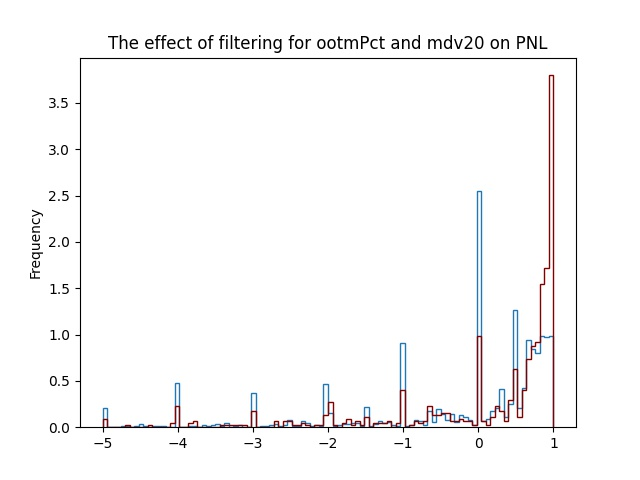

In [11]:
Image("filterGraphs/0.05-0.1_ootmPct&mdv20.jpg")

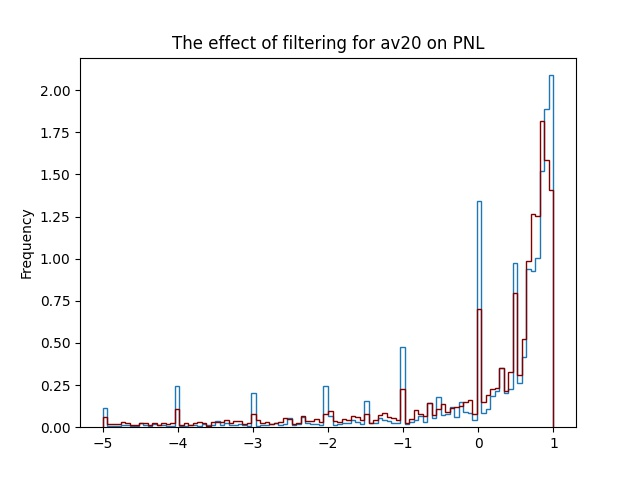

In [12]:
Image("filterGraphs/0.1-0.2_av20.jpg")

In [13]:
# Consolidating all the stats into one dataframe
df = pd.DataFrame(
    columns=[
        "sample",
        "PNLmean",
        "pctWins",
        "winPNLmean",
        "pctTradeOpportunitiesLeft",
        "pctRowsLeft",
        "numTrades",
        "f1Filter",
        "f2Filter",
        "deltaRange",
        "PNLsum",
    ]
)
for dRange in dRanges:
    df2 = pd.read_csv(f"filterGraphs/{dRange[0]}-{dRange[1]}overallStats.csv")
    df2["deltaRange"] = f"{dRange[0]}-{dRange[1]}"
    df = pd.concat([df, df2], ignore_index=True)
df = df.drop(columns=["Unnamed: 0",'pctDaysLeft'])

In [14]:
df.head()

,sample,PNLmean,pctWins,winPNLmean,pctTradeOpportunitiesLeft,pctRowsLeft,numTrades,f1Filter,f2Filter,deltaRange,PNLsum
0,SignalConfidence&ootmPct,-8.471956,0.264622,0.631188,0.075960,0.056611,9455,NaN,1.170230e+00,0.05-0.1,-4802.57000
1,SignalConfidence&spreadPcnt,-1.413163,0.590535,0.676208,0.091381,0.084390,13249,NaN,3.448276e-01,0.05-0.1,-3207.81000
2,SignalConfidence&av20,-6.660029,0.507621,0.640509,0.031452,0.068107,2362,NaN,9.080050e+03,0.05-0.1,-1008.94006
3,SignalConfidence&mdv20,-7.692929,0.509213,0.651878,0.033846,0.075287,2388,NaN,4.386530e+08,0.05-0.1,-1325.15990
4,SignalConfidence&dummy,-9.025393,0.250933,0.601683,0.161524,0.179555,29478,NaN,NaN,0.05-0.1,-16508.55900


In [15]:
print('Size of summary stats dataframe:', df.shape)

Size of summary stats dataframe: (319, 11)


At this point, I sorted by average PNL to find the best filtering. However, I also used the other statistics to provide context to each example. 